<center><h1>Final Project: Genre Prediction Based on Movie Plot<center><h1>




Prabhjot Kaur,
B00843735



# Introduction


Text classification or categorization is an age-old problem in the field of Natural Language Processing(NLP). The main aim of the text classification is to assign labels to the textual components which can be sentences, paragraphs or documents. Since text is an unstructured data, extracting insights from text can be very challenging. Automatic labeling or automatic text classification can be done with the help of machine learning methods. 
In this project, movie genres are predicted based on movie plot summaries using two different machine learning methods. The two machine learning models are used for predicting movie genres based on plot summaries, namely, Support Vector Machine and MLP Classifier.


# Data pre-processing


In this section, the movie plots dataset downloaded from Kaggle open datasets is imported into pandas dataframe. After importing the dataset, various features were analysed for the data pre-processing task. The dataset contains 6,083 movie plots which do not have assigned genres which were removed. New dataframe is created which only contains movie plot summary and genre.

In [1]:
import pandas as pd
movie_data = pd.read_csv("wiki_movie_plots_deduped.csv")

In [2]:
movie_data.shape

(34886, 8)

In [3]:
movie_data.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."


In [4]:
movie_data['Genre'].nunique()

2265

In [5]:
drop_indices = movie_data[movie_data["Genre"] == "unknown" ].index

In [6]:
movie_data.drop(drop_indices, inplace=True)
train_df = movie_data[['Plot','Genre']]
train_df

,Plot,Genre
6,The film opens with two bandits breaking into ...,western
7,The film is about a family who move to the sub...,comedy
10,The Rarebit Fiend gorges on Welsh rarebit at a...,short
11,The film features a train traveling through th...,short action/crime western
12,Irish villager Kathleen is a tenant of Captain...,short film
...,...,...
34877,"Zeynep lost her job at weaving factory, and he...",drama film
34882,"Two musicians, Salih and Gürkan, described the...",comedy
34883,"Zafer, a sailor living with his mother Döndü i...",comedy
34884,The film centres around a young woman named Am...,romantic comedy


## Data Visualization


Various features of dataset were analysed using data visualization. Movies belonging to different origin were visualized using bar chart. As, can be seen from the plot more than 16,000 movies are of American origin. Similarly, number of movies belonging to different genres were also visualized using bar chart and it can be observed that around 50% of movies belong to comedy and drama genre.

In [7]:
origin_df = movie_data.groupby('Origin/Ethnicity')['Origin/Ethnicity'].count().reset_index(name='count').sort_values(['count'], ascending=False)

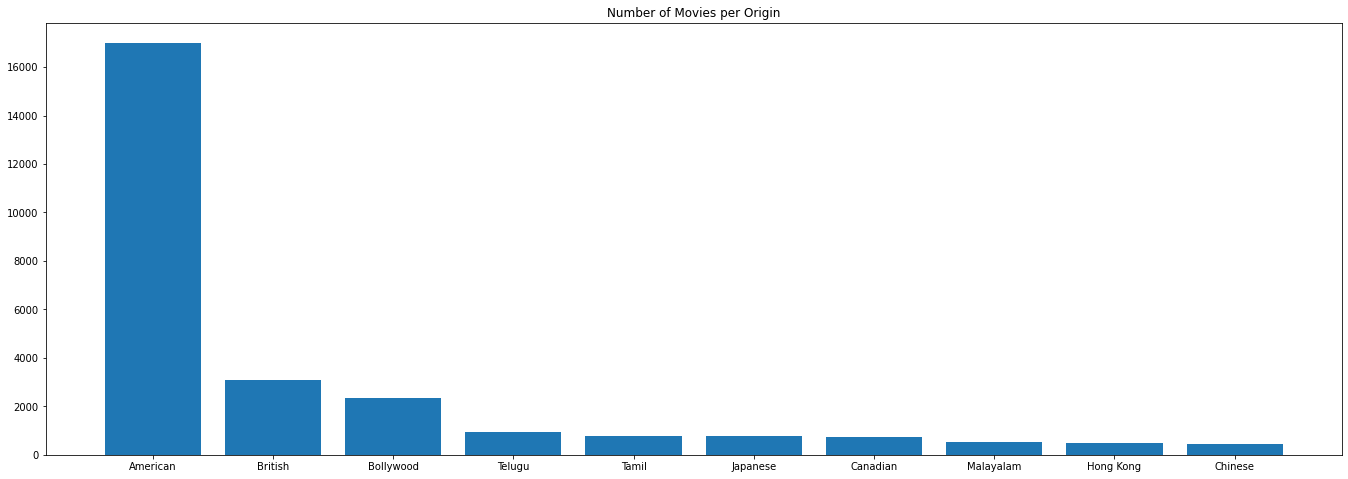

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 6))
ax = fig.add_axes([0,0,1,1])
origin = origin_df.iloc[:10,0]
count = origin_df.iloc[:10,1]
ax.bar(origin,count)
plt.title('Number of Movies per Origin')
plt.show()

In [9]:
genre_df = train_df.groupby('Genre')['Genre'].count().reset_index(name='count').sort_values(['count'], ascending=False)

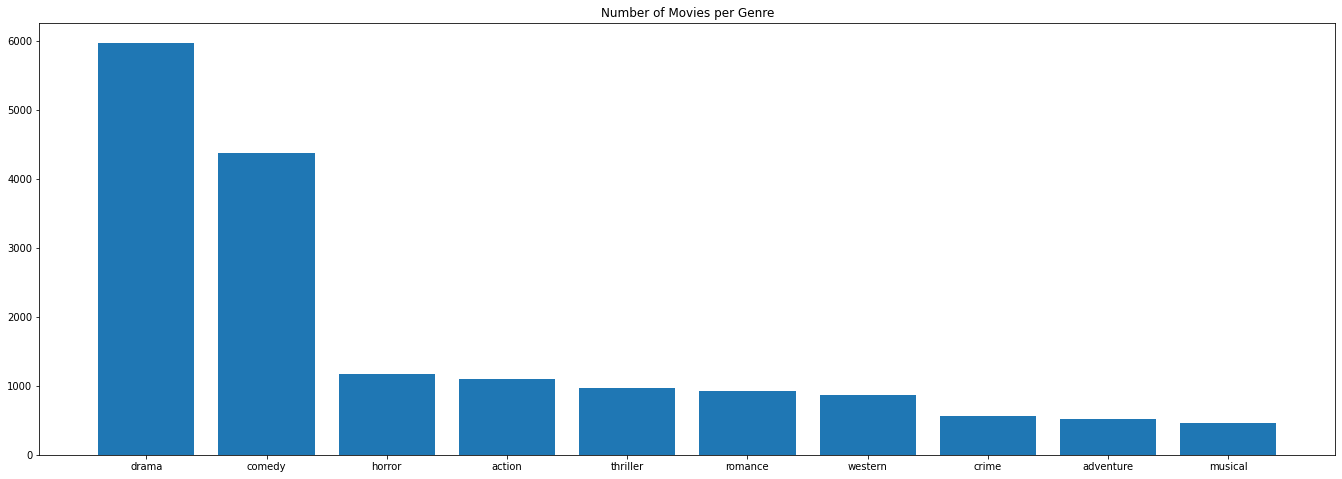

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 6))
ax = fig.add_axes([0,0,1,1])
genres = genre_df.iloc[0:10,0]
count = genre_df.iloc[0:10,1]
ax.bar(genres,count)
plt.title('Number of Movies per Genre')
plt.show()

## Word Embeddings

In this section, word embeddings were created for movie plots which can be further used for clustering and classification tasks . Plot summaries were converted to word embedding using pre-trained BERT base uncased model.The pre-trained transformer models in BERT use language comprehension feature extractors to give accurate word representations and give better model performance.

In [11]:
%%capture 
!pip install -U librosa pydub SpeechRecognition transformers

In [12]:
from transformers import pipeline
import numpy as np
import tqdm

model_name = 'bert-base-uncased'
pipe = pipeline(task='feature-extraction', model=model_name, framework='pt',device=0)

plot_embeddings = []
for plot in tqdm.notebook.tqdm(train_df['Plot']):
    plot = plot[:512]
    embeddings = np.array(pipe(plot)).squeeze(0)
    plot_embeddings += [embeddings[1:-1,:].mean(axis=0)]

In [13]:
len(plot_embeddings)

28803

## Clustering

In this section, clustering is performed on dataset to remove multi-labels from the genre field and assign the most influential genre according to the plot summary. K-means clustering algorithm is used for this task. After, getting the assigned clusters for the entire dataset, each cluster is grouped by genres and if the genre does not belong to top eleven occuring it is reassigned to the most occuring genre in that cluster. This decision is based on the assumption that since BERT word embeddings are given as input to the model, all related plot summaries should be in each cluster. After reassigning of the labels is done, genres are encoded using label encoder.

In [14]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=10)
kmeans.fit(plot_embeddings)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [15]:
%%capture
train_df['cluster'] = labels

In [16]:
train_df.groupby('cluster')['cluster'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,cluster,count
1,1,4414
4,4,4373
6,6,4352
7,7,3868
3,3,3326
5,5,2457
2,2,1845
8,8,1786
9,9,1418
0,0,964


In [17]:
%%capture
for i in range(10):
  genreCount = train_df[(train_df["cluster"]==i)].groupby('Genre')['Genre'].count().reset_index(name='count').sort_values(['count'], ascending=False)
  genreVal = genreCount.iloc[0]
  replaceIndices = train_df[(~train_df.Genre.isin(['drama', 'comedy', 'horror','action','thriller',
                                'romance','western','crime','adventure','musical','science fiction']))& (train_df["cluster"]==i)].index
  train_df.loc[replaceIndices,'Genre']=genreVal['Genre']

In [18]:
train_df.groupby('Genre')['Genre'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,Genre,count
4,drama,14672
2,comedy,6131
8,science fiction,1420
5,horror,1167
0,action,1098
9,thriller,966
7,romance,923
10,western,865
3,crime,568
1,adventure,526


In [19]:
%%capture
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df["encoded_genre"] = label_encoder.fit_transform(train_df["Genre"].tolist())

In [20]:
label_encoder.transform(['action','adventure', 'comedy','crime','drama','horror','musical','romance',
                         'science fiction','thriller','western'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Additionaly,embeddings are visualised to see if they form any clusters. Here we are using t-SNE to project the plot embedding on to a plane.

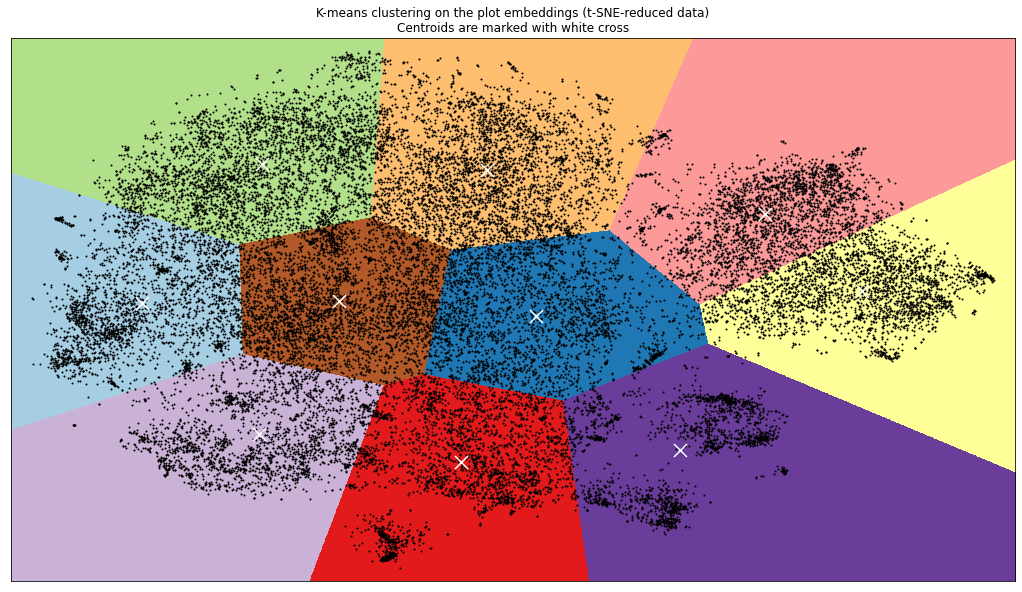

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

reduced_data = TSNE(n_components=2,perplexity=45,n_iter=500).fit_transform(plot_embeddings)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the plot embeddings (t-SNE-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Building dataset


The movie dataset is splitted using train\_test\_split() method which is stratified by genre field to have balance of classes in both test and train data. These sample are converted to word embedding using BERT model. After conversion, train data had shape 23042 X 768 and test data had shape 5761 X 768. Similarly, train labels have shape 23042 X 1 and test data have shape 5761 X 1. These train and test data set are used in both the models, Support vector machine and Multilayer perceptron.

In [21]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_df, test_size=0.2, stratify=train_df["Genre"], random_state=42)

In [22]:
emb_modA = []
for plot in tqdm.notebook.tqdm(train_set['Plot']):
    plot = plot[:512]
    embeddings = np.array(pipe(plot)).squeeze(0)
    emb_modA += [embeddings[1:-1,:].mean(axis=0)]
 
train_X = pd.DataFrame(emb_modA)
train_X.shape

(23042, 768)

In [23]:
emb_modA = []
for plot in tqdm.notebook.tqdm(test_set['Plot']):
    plot = plot[:512]
    embeddings = np.array(pipe(plot)).squeeze(0)
    emb_modA += [embeddings[1:-1,:].mean(axis=0)]
 
test_X = pd.DataFrame(emb_modA)
test_X.shape

(5761, 768)

In [24]:
train_Y = train_set['encoded_genre']
train_Y.shape

(23042,)

In [25]:
test_Y = test_set['encoded_genre']
test_Y.shape

(5761,)

# Model A- Support Vector Machine


Sklearn's SVC(Support Vector Classification) model is used and passed the training data to train the model. Once the model is trained, test data was passed to predict the genre values. Later, classification report is generated which gives performance metrics like precision, recall, f1-score for each class and also accuracy, f1-macro and f1-weighted of the model.

In [26]:
from sklearn import svm
modelA = svm.SVC()
modelA.fit(train_X, train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
from sklearn.metrics import classification_report
y_pred_modelA = modelA.predict(test_X)

In [28]:
print(classification_report(test_Y, y_pred_modelA, target_names=['action','adventure', 'comedy','crime','drama','horror','musical','romance',
'science fiction','thriller','western']))

                 precision    recall  f1-score   support

         action       0.25      0.00      0.01       220
      adventure       0.25      0.02      0.04       105
         comedy       0.67      0.43      0.53      1226
          crime       0.00      0.00      0.00       114
          drama       0.62      0.92      0.74      2935
         horror       0.59      0.27      0.37       233
        musical       0.00      0.00      0.00        93
        romance       0.00      0.00      0.00       185
science fiction       0.76      0.79      0.77       284
       thriller       0.00      0.00      0.00       193
        western       0.76      0.73      0.75       173

       accuracy                           0.63      5761
      macro avg       0.35      0.29      0.29      5761
   weighted avg       0.55      0.63      0.56      5761



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




# Model B- MLP Classifier

Multi-layer Perceptron is a class of feed-forward artificial neural network. Any neural network with input layer, hidden layer(s) and output layer where all neurons of previous layer are connected to next layer is called feed-forward neural network. This model optimizes the log-loss function using LBFGS, learning rate of 1e-5 is used. It has three hidden layers of 20,10,2 neurons and runs for 1500 iterations. 

In [29]:
%%capture
from sklearn.neural_network import MLPClassifier
modelB = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,10,2), random_state=1, max_iter=1500)
modelB.fit(train_X, train_Y)

In [30]:
y_pred_modelB = modelB.predict(test_X)

In [31]:
print(classification_report(test_Y, y_pred_modelB, target_names=['action','adventure', 'comedy','crime','drama','horror','musical','romance',
                                                                 'science fiction','thriller','western']))

                 precision    recall  f1-score   support

         action       0.15      0.05      0.08       220
      adventure       0.00      0.00      0.00       105
         comedy       0.60      0.41      0.48      1226
          crime       0.00      0.00      0.00       114
          drama       0.62      0.85      0.72      2935
         horror       0.37      0.43      0.40       233
        musical       0.40      0.06      0.11        93
        romance       0.00      0.00      0.00       185
science fiction       0.62      0.72      0.67       284
       thriller       0.00      0.00      0.00       193
        western       0.60      0.62      0.61       173

       accuracy                           0.60      5761
      macro avg       0.31      0.29      0.28      5761
   weighted avg       0.52      0.60      0.54      5761



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Comparison

Cross-validation is used to evaluate the performance of both the models. As the MLP classifier contains random component that is weight initialization, so performance cannot be compared based on single session. Thus, cross-validation is used to resolve this issue, test set is held out and five fold cross validation is performed on that which gives the f1-score as well as accuracy for each run.

In [32]:
from sklearn.model_selection import cross_val_score
f1ScoresModelA = cross_val_score(modelA, train_X, train_Y, cv=5, scoring='f1_macro')
f1ScoresModelA

array([0.28655599, 0.28632543, 0.29243314, 0.29736752, 0.29321301])

In [33]:
accScoresModelA = cross_val_score(modelA, train_X, train_Y, cv=5)
accScoresModelA

array([0.6287698 , 0.633977  , 0.62738715, 0.63020833, 0.63823785])

In [34]:
print("Accuracy ModelA: %0.2f (+/- %0.2f)" % (accScoresModelA.mean(), accScoresModelA.std() * 2))

Accuracy ModelA: 0.63 (+/- 0.01)


In [35]:
%%capture
f1ScoresModelB = cross_val_score(modelB, train_X, train_Y, cv=5, scoring='f1_macro')
accScoresModelB = cross_val_score(modelB, train_X, train_Y, cv=5)

In [36]:
f1ScoresModelB

array([0.2504817 , 0.26400847, 0.18416525, 0.16425405, 0.20594182])

In [37]:
accScoresModelB

array([0.61032762, 0.59188544, 0.58116319, 0.56510417, 0.57226562])

In [38]:
print("Accuracy ModelB: %0.2f (+/- %0.2f)" % (accScoresModelB.mean(), accScoresModelB.std() * 2))

Accuracy ModelB: 0.58 (+/- 0.03)


In [39]:
f1scores =pd.DataFrame({"ModelA": f1ScoresModelA,"ModelB": f1ScoresModelB})

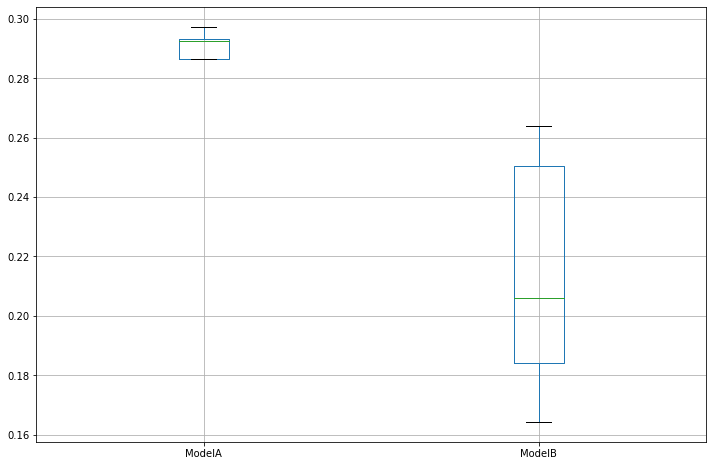

In [40]:
plt.rcParams['figure.figsize'] = [12, 8]
f1scores.boxplot();

P-value is also derived based on cross-validation scores to establish the statistical significance of an observed effect.

In [41]:
import scipy
print("p value: %f2" % scipy.stats.ttest_ind(f1scores['ModelA'], 
                                             f1scores['ModelB'], equal_var=False).pvalue)

p value: 0.0148932


# Conclusion

Although cross-validation average accuracy for both models are almost similar between SVM has 63% accuracy and MLP has 58% accuracy. But P-value for their F1-score is 0.014 which is around 1% which means SVM has better stastical performance as compared to MLP.